# Pylops-distributed - signal processing

In this notebook I will show how to use some of the signal processing operators implemented in *Pylops-distributed*.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import dask.array as da
import pylops
import pylops_distributed

from scipy.sparse.linalg import lsqr
from pylops.utils import dottest
from pylops_distributed.utils import dottest as ddottest
from pylops_distributed.optimization.cg import cg as dcg
from pylops_distributed.optimization.cg import cgls as dcgls

Local cluster

In [2]:
client = pylops_distributed.utils.backend.dask(processes=False, threads_per_worker=2,
                                               n_workers=2)
client

Client Scheduler: inproc://10.0.0.13/4605/1 Dashboard: http://localhost:8787/status,Cluster Workers: 2 Cores: 4 Memory: 8.59 GB


SSH cluster

In [3]:
#client = Client('be-linrgsn045:8786')
#client = pylops_distributed.utils.backend.dask(client='be-linrgsn045:8786')
#client

## Convolve1D

In [4]:
nx = 10
x  = np.zeros(nx)
x[3]=1
offset=4
h = np.arange(-3, 3)
Cop = pylops.signalprocessing.Convolve1D(nx, h=h, offset=offset, dtype='float32', method='direct')
dottest(Cop, nx, nx, verb=True)

y    = Cop*x
xadj = Cop.H*y

print('h= ',h)
print('x= ',x)
print('y= ',y)
print('xadj= ',xadj)

Dot test passed, v^T(Opu)=2.532874 - u^T(Op^Tv)=2.532874
h=  [-3 -2 -1  0  1  2]
x=  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
y=  [-2. -1.  0.  1.  2.  0.  0.  0.  0.  0.]
xadj=  [-4. -1.  4. 10. 10.  2. -4. -7. -6.  0.]


In [5]:
nx = 10
x  = np.zeros(nx)
x[3]=1
offset=4
h = np.arange(-3, 3)
Cop = pylops_distributed.signalprocessing.Convolve1D(nx, h=h, offset=offset, 
                                                     dtype='float32', method='direct', compute=(False, False))
ddottest(Cop, nx, nx, chunks=(nx, nx), verb=True)

xda  = da.from_array(x) 
y    = Cop*xda
xadj = Cop.H*y

print('h= ',h)
print('x= ',x)
print('y= ',y.compute())
print('xadj= ',xadj.compute())

distributed.scheduler - ERROR - Workers don't have promised key: ['inproc://10.0.0.13/4605/3'], ('array-38f6ca7f99545d5022449cb2e5e5ed3c', 0)
NoneType: None
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('array-38f6ca7f99545d5022449cb2e5e5ed3c', 0)": ['inproc://10.0.0.13/4605/3']}
distributed.scheduler - ERROR - Workers don't have promised key: ['inproc://10.0.0.13/4605/3'], ('array-1025797f834471d37010b57f86ea94e9', 0)
NoneType: None
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('array-1025797f834471d37010b57f86ea94e9', 0)": ['inproc://10.0.0.13/4605/3']}


Dot test passed, v^T(Opu)=-1.301490 - u^T(Op^Tv)=-1.301490


distributed.scheduler - ERROR - Workers don't have promised key: ['inproc://10.0.0.13/4605/3'], ('array-6f323f9ce1aa9100032769c10e1cb03a', 0)
NoneType: None
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('array-6f323f9ce1aa9100032769c10e1cb03a', 0)": ['inproc://10.0.0.13/4605/3']}


h=  [-3 -2 -1  0  1  2]
x=  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
y=  [-2. -1.  0.  1.  2.  0.  0.  0.  0.  0.]
xadj=  [-4. -1.  4. 10. 10.  2. -4. -7. -6.  0.]


Dot test passed, v^T(Opu)=-15.819862 - u^T(Op^Tv)=-15.819862


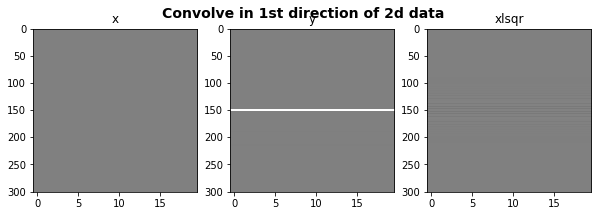

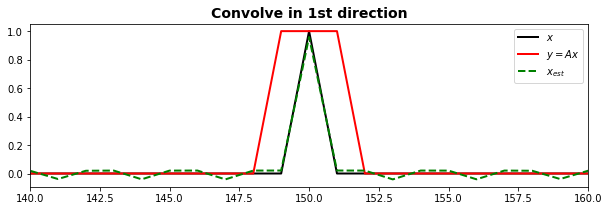

In [6]:
nt = 301
nx = 20
dt = 0.004
t  = np.arange(nt)*dt
x  = np.zeros((nt, nx))
x[int(nt/2),:] = 1

h = np.ones(3)
hcenter=1

Cop = pylops.signalprocessing.Convolve1D(nt*nx, h=h, offset=hcenter, dims=[nt,nx], dir=0, dtype='float32')
dottest(Cop, nt*nx, nt*nx, verb=True)

y    = Cop*x.flatten()

xlsqr, istop, itn, r1norm, r2norm = lsqr(Cop, y, damp=0, iter_lim=30, show=0)[0:5]

y = y.reshape(nt,nx)
xlsqr = xlsqr.reshape(nt,nx)

fig, axs = plt.subplots(1,3,figsize=(10,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0].imshow(x, cmap='gray', vmin=-1, vmax=1)
axs[1].imshow(y, cmap='gray', vmin=-1, vmax=1)
axs[2].imshow(xlsqr, cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('x'),axs[0].axis('tight')
axs[1].set_title('y'),axs[1].axis('tight')
axs[2].set_title('xlsqr'),axs[2].axis('tight');

fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(x[:, int(nx/2)],'k'      ,lw=2, label=r'$x$')
ax.plot(y[:, int(nx/2)],'r'      ,lw=2, label=r'$y=Ax$')
ax.plot(xlsqr[:, int(nx/2)],'--g',lw=2, label=r'$x_{est}$')
ax.set_title('Convolve in 1st direction',fontsize=14, fontweight='bold')
ax.legend();
ax.set_xlim(140,160);

In [7]:
xda = da.from_array(x, chunks=(nt,nx//4))
Cop = pylops_distributed.signalprocessing.Convolve1D(nt*nx, h=h, 
                                                     offset=hcenter, dims=[nt,nx], dir=0, 
                                                     chunks=((nt,nx//4), (nt,nx//4)),
                                                     compute=(False, False), 
                                                     dtype='float32')
ddottest(Cop, nt*nx, nt*nx, chunks=(nx*nt, nx*nt), verb=True)

yda    = Cop*xda.flatten()
xcgda, niter = dcg(Cop, yda, niter=30)

y = yda.compute().reshape(nt,nx)
xcg = xcgda.compute().reshape(nt,nx)

Dot test passed, v^T(Opu)=4598.119493 - u^T(Op^Tv)=4598.119493


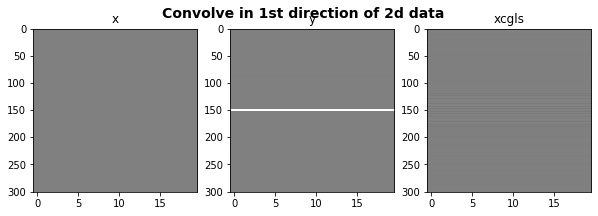

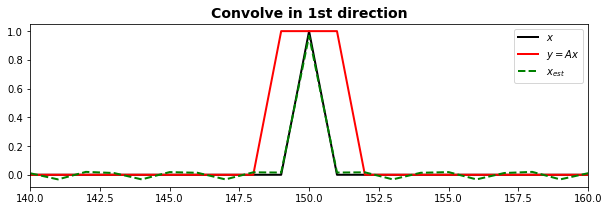

In [8]:
fig, axs = plt.subplots(1,3,figsize=(10,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0].imshow(x, cmap='gray', vmin=-1, vmax=1)
axs[1].imshow(y, cmap='gray', vmin=-1, vmax=1)
axs[2].imshow(xcg, cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('x'),axs[0].axis('tight')
axs[1].set_title('y'),axs[1].axis('tight')
axs[2].set_title('xcgls'),axs[2].axis('tight');

fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(x[:, int(nx/2)],'k'      ,lw=2, label=r'$x$')
ax.plot(y[:, int(nx/2)],'r'      ,lw=2, label=r'$y=Ax$')
ax.plot(xcg[:, int(nx/2)],'--g',lw=2, label=r'$x_{est}$')
ax.set_title('Convolve in 1st direction',fontsize=14, fontweight='bold')
ax.legend();
ax.set_xlim(140,160);

## FFT2

Apply 2d Fourier transform to 2d data

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 1.04858e+06 rows  and    20100 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =        3
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.168e+04  1.168e+04    1.0e+00  8.6e-05
     1 -3.57185e-15   1.424e-11  1.424e-11    1.2e-15  9.7e-01   1.0e+00  1.0e+00
 
LSQR finished
Ax - b is small enough, given atol, btol                  
 
istop =       1   r1norm = 1.4e-11   anorm = 1.0e+00   arnorm = 1.4e-11
itn   =       1   r2norm = 1.4e-11   acond = 1.0e+00   xnorm  = 1.2e+04
 


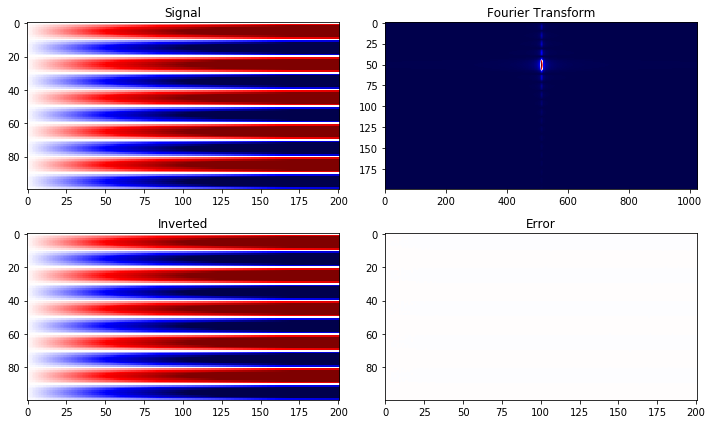

In [12]:
dt, dx = 0.005, 5
nt,nx  = 100, 201
t      = np.arange(nt)*dt
x      = np.arange(nx)*dx
f0     = 10
nfft   = 2**10
d      = np.outer(np.sin(2*np.pi*f0*t), np.arange(nx)+1)

FFTop = pylops.signalprocessing.FFT2D(dims=[nt,nx], nffts=[nfft,nfft], sampling=[dt,dx])
dottest(FFTop, nfft*nfft, nt*nx, complexflag=2)

D    = FFTop*d.flatten()
#dinv = FFTop.H*D # adjoint is inverse for fft
dinv, istop, itn, r1norm, r2norm = lsqr(FFTop, D, iter_lim=3, show=2)[0:5]
dinv = np.real(dinv).reshape(nt,nx)

fig, axs = plt.subplots(2,2,figsize=(10,6))
axs[0][0].imshow(d, vmin=-100, vmax=100, cmap='seismic')
axs[0][0].set_title('Signal')
axs[0][0].axis('tight')
axs[0][1].imshow(np.abs(np.fft.fftshift(D.reshape(nfft,nfft),axes=1)[:200,:]), cmap='seismic')
axs[0][1].set_title('Fourier Transform')
axs[0][1].axis('tight')
axs[1][0].imshow(dinv, vmin=-100, vmax=100, cmap='seismic')
axs[1][0].set_title('Inverted')
axs[1][0].axis('tight')
axs[1][1].imshow(d-dinv, vmin=-100, vmax=100, cmap='seismic')
axs[1][1].set_title('Error')
axs[1][1].axis('tight')
fig.tight_layout()

29
1


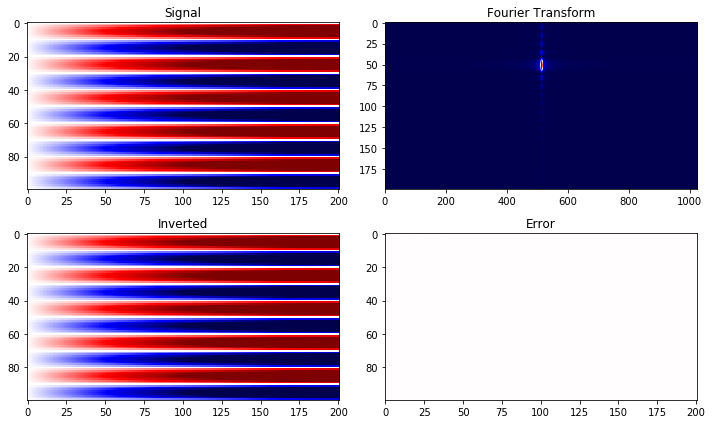

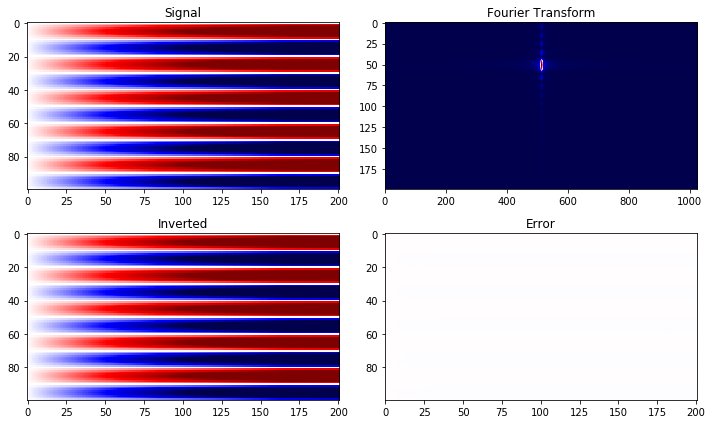

In [13]:
dd = da.from_array(d, chunks=(nt, nx))

dFFTop = pylops_distributed.signalprocessing.FFT2D(dims=[nt,nx], nffts=[nfft,nfft], 
                                                   sampling=[dt,dx], compute=(False, False))
ddottest(dFFTop, nfft*nfft, nt*nx, chunks=(nfft*nfft, nt*nx), complexflag=2)

D    = dFFTop*dd.flatten()
#dinv = dFFTop.H * D

# Create all graph and compute (cannot check tol condition)
dinv, its = dcgls(dFFTop, D, x=da.zeros(nt*nx), niter=30)
dinv = np.real(dinv.compute()).reshape(nt,nx)
print(its)

fig, axs = plt.subplots(2,2,figsize=(10,6))
axs[0][0].imshow(d, vmin=-100, vmax=100, cmap='seismic')
axs[0][0].set_title('Signal')
axs[0][0].axis('tight')
axs[0][1].imshow(np.abs(np.fft.fftshift(D.reshape(nfft,nfft),axes=1)[:200,:]), cmap='seismic')
axs[0][1].set_title('Fourier Transform')
axs[0][1].axis('tight')
axs[1][0].imshow(dinv, vmin=-100, vmax=100, cmap='seismic')
axs[1][0].set_title('Inverted')
axs[1][0].axis('tight')
axs[1][1].imshow(d-dinv, vmin=-100, vmax=100, cmap='seismic')
axs[1][1].set_title('Error')
axs[1][1].axis('tight')
fig.tight_layout()


# Create graph while persisting (can check tol condition)
dinv, its = dcgls(dFFTop, D, niter=30, tol=1e-5, compute=False, client=client)
dinv = np.real(dinv.compute()).reshape(nt,nx)
print(its)

fig, axs = plt.subplots(2,2,figsize=(10,6))
axs[0][0].imshow(d, vmin=-100, vmax=100, cmap='seismic')
axs[0][0].set_title('Signal')
axs[0][0].axis('tight')
axs[0][1].imshow(np.abs(np.fft.fftshift(D.reshape(nfft,nfft),axes=1)[:200,:]), cmap='seismic')
axs[0][1].set_title('Fourier Transform')
axs[0][1].axis('tight')
axs[1][0].imshow(dinv, vmin=-100, vmax=100, cmap='seismic')
axs[1][0].set_title('Inverted')
axs[1][0].axis('tight')
axs[1][1].imshow(d-dinv, vmin=-100, vmax=100, cmap='seismic')
axs[1][1].set_title('Error')
axs[1][1].axis('tight')
fig.tight_layout()

dask.array<sum-aggregate, shape=(), dtype=complex128, chunksize=()>
dask.array<sum-aggregate, shape=(), dtype=complex128, chunksize=()>
1
(136355050.00000006+0j)
(2.9183223935386007e-24+0j)
1


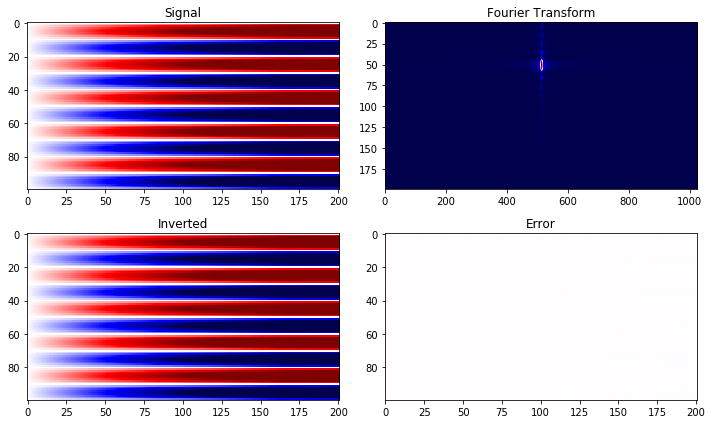

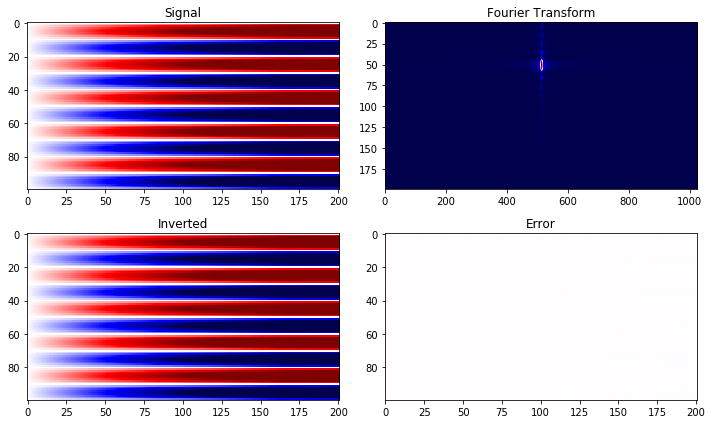

In [15]:
# with compute the tol condition can be checked
dFFTop = pylops_distributed.signalprocessing.FFT2D(dims=[nt,nx], nffts=[nfft,nfft], 
                                                   sampling=[dt,dx])

dinv, its = dcg(dFFTop.H * dFFTop, dFFTop.H * D,  niter=30, client=client)
print(its)
dinv = np.real(dinv.compute()).reshape(nt,nx)

fig, axs = plt.subplots(2,2,figsize=(10,6))
axs[0][0].imshow(d, vmin=-100, vmax=100, cmap='seismic')
axs[0][0].set_title('Signal')
axs[0][0].axis('tight')
axs[0][1].imshow(np.abs(np.fft.fftshift(D.reshape(nfft,nfft),axes=1)[:200,:]), cmap='seismic')
axs[0][1].set_title('Fourier Transform')
axs[0][1].axis('tight')
axs[1][0].imshow(dinv, vmin=-100, vmax=100, cmap='seismic')
axs[1][0].set_title('Inverted')
axs[1][0].axis('tight')
axs[1][1].imshow(d-dinv, vmin=-100, vmax=100, cmap='seismic')
axs[1][1].set_title('Error')
axs[1][1].axis('tight')
fig.tight_layout()

# with compute the tol condition can be checked
dFFTop = pylops_distributed.signalprocessing.FFT2D(dims=[nt,nx], nffts=[nfft,nfft], 
                                                   sampling=[dt,dx], todask=(True, True))

dinv, its = dcg(dFFTop.H * dFFTop, dFFTop.H * D, compute=True, niter=30)
print(its)
dinv = np.real(dinv).reshape(nt,nx)
fig, axs = plt.subplots(2,2,figsize=(10,6))
axs[0][0].imshow(d, vmin=-100, vmax=100, cmap='seismic')
axs[0][0].set_title('Signal')
axs[0][0].axis('tight')
axs[0][1].imshow(np.abs(np.fft.fftshift(D.reshape(nfft,nfft),axes=1)[:200,:]), cmap='seismic')
axs[0][1].set_title('Fourier Transform')
axs[0][1].axis('tight')
axs[1][0].imshow(dinv, vmin=-100, vmax=100, cmap='seismic')
axs[1][0].set_title('Inverted')
axs[1][0].axis('tight')
axs[1][1].imshow(d-dinv, vmin=-100, vmax=100, cmap='seismic')
axs[1][1].set_title('Error')
axs[1][1].axis('tight')
fig.tight_layout()